In [48]:
# Importing Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import uniform
import json
import csv
import seaborn as sns
from citipy import citipy
import requests
from datetime import datetime as dt
from config import weathermap_api_key
from config import googlemap_api_key

In [49]:
# Build data frame of randomly generated lat and long along equator
location_data = pd.DataFrame()
location_data['rand_lat'] = [np.random.uniform(-90,90) for x in range(1500)]
location_data['rand_lng'] = [np.random.uniform(-180, 180) for x in range(1500)]

# Place holder for closest city and country column
location_data['closest_city'] = ""
location_data['country'] = ""

#find and add closest city and country code using citipy
for index, row in location_data.iterrows():
    lat = row['rand_lat']
    lng = row['rand_lng']
    location_data.set_value(index, 'closest_city', citipy.nearest_city(lat, lng).city_name)
    location_data.set_value(index, 'country', citipy.nearest_city(lat, lng).country_code)

    
location_data

/Users/Karthik/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/Users/Karthik/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app


,rand_lat,rand_lng,closest_city,country
0,-15.602053,-155.832359,faanui,pf
1,7.216893,67.381275,kulhudhuffushi,mv
2,60.975646,53.284606,ust-kulom,ru
3,-35.257613,-132.851113,rikitea,pf
4,49.413542,-26.701957,lagoa,pt
5,-58.640371,15.237928,hermanus,za
6,87.784021,-165.133336,barrow,us
7,-19.029723,149.073439,bowen,au
8,-31.500250,55.486699,saint-joseph,re
9,65.451106,-116.331946,yellowknife,ca


In [50]:
# delete repeated cities and find unique city count
location_data = location_data.drop_duplicates(subset='closest_city').sample(n=600).reset_index()

print(len(location_data))

600


In [51]:
#Add new columns and dropped index
location_data["Temp"] = ""
location_data["Humidity"] = ""
location_data["Date"] = ""
location_data["Wind Speed"] = ""
location_data["Cloudiness"] = ""
del location_data['index']
location_data.head()

,rand_lat,rand_lng,closest_city,country,Temp,Humidity,Date,Wind Speed,Cloudiness
0,3.912769,-2.781305,axim,gh,,,,,
1,66.280382,-148.426847,college,us,,,,,
2,27.586403,-17.854489,los llanos de aridane,es,,,,,
3,65.337554,-59.578626,sisimiut,gl,,,,,
4,26.786424,78.192916,ambah,in,,,,,


In [52]:
#Looping through each city in Openweathermap

units = "Imperial"

counter = 0
for index, row in location_data.iterrows():
    target_url = "http://api.openweathermap.org/data/2.5/weather?units=%s&APPID=%s&q=%s" % (units,weathermap_api_key, row['closest_city'])
#Trying to catch only cities that are available in Openweather map   
    try:
        cities_data = requests.get(target_url).json()
        location_data.set_value(index, "Temp", cities_data["main"]["temp_max"])
        location_data.set_value(index, "Humidity", cities_data["main"]["humidity"])
        location_data.set_value(index, "Date", cities_data["dt"])
        location_data.set_value(index, "Wind Speed", cities_data["wind"]["speed"])
        location_data.set_value(index, "Cloudiness", cities_data["clouds"]["all"])
        print("------------------------")
        print("Proceesing Record : " , counter, '|' , cities_data["name"])
        print(target_url)
  #Missing cities in openweather map are skipped
    except:
          print('Missing Data for city') 
    counter = counter + 1
   

/Users/Karthik/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
/Users/Karthik/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':
/Users/Karthik/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
/Users/Karthik/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/Users/Karthik/an

------------------------
Proceesing Record :  0 | Axim
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=axim
------------------------
Proceesing Record :  1 | College
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=college
------------------------
Proceesing Record :  2 | Los Llanos de Aridane
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=los llanos de aridane
------------------------
Proceesing Record :  3 | Sisimiut
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=sisimiut
------------------------
Proceesing Record :  4 | Ambah
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=ambah
------------------------
Proceesing Record :  5 | Tiznit
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc538

------------------------
Proceesing Record :  53 | Farah
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=farah
------------------------
Proceesing Record :  54 | Harsin
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=harsin
------------------------
Proceesing Record :  55 | Chokurdakh
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=chokurdakh
------------------------
Proceesing Record :  56 | Mashhad
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=mashhad
------------------------
Proceesing Record :  57 | Vestmannaeyjar
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=vestmannaeyjar
Missing Data for city
------------------------
Proceesing Record :  59 | Matay
http://api.openweathermap.org/data/2.5/weather?units=Impe

------------------------
Proceesing Record :  104 | Wynyard
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=wynyard
------------------------
Proceesing Record :  105 | San Angelo
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=san angelo
------------------------
Proceesing Record :  106 | Sao Joao da Barra
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=sao joao da barra
------------------------
Proceesing Record :  107 | Saint-Georges
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=saint-georges
------------------------
Proceesing Record :  108 | Bucerias
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=bucerias
------------------------
Proceesing Record :  109 | Bandarbeyla
http://api.openweathermap.org/data/2.5/we

------------------------
Proceesing Record :  155 | Hofn
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=hofn
------------------------
Proceesing Record :  156 | Kijang
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=kijang
Missing Data for city
------------------------
Proceesing Record :  158 | Santa Cruz Cabralia
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=santa cruz cabralia
------------------------
Proceesing Record :  159 | Quatre Cocos
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=quatre cocos
------------------------
Proceesing Record :  160 | Tete
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=tete
------------------------
Proceesing Record :  161 | Burgersdorp
http://api.openweathermap.org/data/2.5/

------------------------
Proceesing Record :  210 | Busselton
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=busselton
------------------------
Proceesing Record :  211 | Port Hardy
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=port hardy
------------------------
Proceesing Record :  212 | Udachnyy
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=udachnyy
------------------------
Proceesing Record :  213 | Kainantu
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=kainantu
------------------------
Proceesing Record :  214 | Nizhniy Kuranakh
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=nizhniy kuranakh
------------------------
Proceesing Record :  215 | Hithadhoo
http://api.openweathermap.org/data/2.5/weather?unit

------------------------
Proceesing Record :  266 | Aktau
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=aktau
------------------------
Proceesing Record :  267 | Cienfuegos
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=cienfuegos
------------------------
Proceesing Record :  268 | Ishurdi
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=ishurdi
------------------------
Proceesing Record :  269 | Raudeberg
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=raudeberg
------------------------
Proceesing Record :  270 | Lorengau
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=lorengau
------------------------
Proceesing Record :  271 | Punta Arenas
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a745

------------------------
Proceesing Record :  315 | Pisco
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=pisco
------------------------
Proceesing Record :  316 | Beringovskiy
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=beringovskiy
------------------------
Proceesing Record :  317 | Ajaccio
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=ajaccio
------------------------
Proceesing Record :  318 | Beitbridge
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=beitbridge
------------------------
Proceesing Record :  319 | Sakaraha
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=sakaraha
------------------------
Proceesing Record :  320 | Manicore
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7

------------------------
Proceesing Record :  366 | Sorland
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=sorland
------------------------
Proceesing Record :  367 | Acapulco
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=acapulco
------------------------
Proceesing Record :  368 | Hilo
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=hilo
Missing Data for city
------------------------
Proceesing Record :  370 | Victoria
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=victoria
------------------------
Proceesing Record :  371 | Tilichiki
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=tilichiki
------------------------
Proceesing Record :  372 | Namatanai
http://api.openweathermap.org/data/2.5/weather?units=Imperi

------------------------
Proceesing Record :  420 | Nouakchott
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=nouakchott
------------------------
Proceesing Record :  421 | Ulaanbaatar
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=ulaanbaatar
------------------------
Proceesing Record :  422 | Tual
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=tual
------------------------
Proceesing Record :  423 | Dukat
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=dukat
------------------------
Proceesing Record :  424 | Kruisfontein
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=kruisfontein
------------------------
Proceesing Record :  425 | Bilibino
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7

------------------------
Proceesing Record :  472 | Severo-Kurilsk
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=severo-kurilsk
------------------------
Proceesing Record :  473 | Bam
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=bam
------------------------
Proceesing Record :  474 | San Quintin
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=san quintin
------------------------
Proceesing Record :  475 | Borovskoy
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=borovskoy
------------------------
Proceesing Record :  476 | Vanimo
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=vanimo
Missing Data for city
------------------------
Proceesing Record :  478 | Opotiki
http://api.openweathermap.org/data/2.5/weather?

------------------------
Proceesing Record :  525 | Georgetown
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=georgetown
------------------------
Proceesing Record :  526 | Brae
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=brae
------------------------
Proceesing Record :  527 | Zhezkazgan
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=zhezkazgan
------------------------
Proceesing Record :  528 | Bintulu
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=bintulu
------------------------
Proceesing Record :  529 | Havre-Saint-Pierre
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=havre-saint-pierre
------------------------
Proceesing Record :  530 | Freeport
http://api.openweathermap.org/data/2.5/weather?units=Imp

------------------------
Proceesing Record :  575 | Aklavik
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=aklavik
------------------------
Proceesing Record :  576 | Victoria
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=labuan
------------------------
Proceesing Record :  577 | Tha Maka
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=tha maka
------------------------
Proceesing Record :  578 | Alofi
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=alofi
------------------------
Proceesing Record :  579 | Yibin
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c811e6fc1&q=yibin
------------------------
Proceesing Record :  580 | Igarka
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=a7455bc5382fa7f12ec6878c

In [58]:
# Filling value as NaN for cities not found in OpenWeather map
location_data=location_data.replace('', np.NaN,regex=True)
# Drop all the rows where city is not found in OpenWeather map
location_data = location_data.dropna(axis=0, how='all',subset=['Temp'])
location_data

,rand_lat,rand_lng,closest_city,country,Temp,Humidity,Date,Wind Speed,Cloudiness
0,3.912769,-2.781305,axim,gh,76.38,100.0,06/17/2018,15.79,92.0
1,66.280382,-148.426847,college,us,64.40,59.0,06/17/2018,4.70,90.0
2,27.586403,-17.854489,los llanos de aridane,es,68.00,77.0,06/17/2018,17.22,75.0
3,65.337554,-59.578626,sisimiut,gl,35.07,98.0,06/17/2018,1.48,48.0
4,26.786424,78.192916,ambah,in,84.66,61.0,06/17/2018,5.06,80.0
5,28.535622,-9.132423,tiznit,ma,64.86,87.0,06/17/2018,2.37,56.0
6,63.145975,-148.562543,palmer,us,60.80,59.0,06/17/2018,4.70,90.0
7,37.960411,-119.645706,south lake tahoe,us,64.40,57.0,06/17/2018,12.75,40.0
8,15.105676,-101.457111,san jeronimo,mx,53.61,40.0,06/17/2018,2.37,0.0
9,-25.851546,-22.678249,caravelas,br,75.84,100.0,06/17/2018,13.00,12.0


In [59]:
# Formatting date and storing output in CSV file
location_data["Date"] = dt.now().strftime("%m/%d/%Y")
Date = dt.now().strftime("%m/%d/%Y")
location_data.to_csv("Equatorcitytemp.csv",encoding="utf-8", index=False)
location_data

,rand_lat,rand_lng,closest_city,country,Temp,Humidity,Date,Wind Speed,Cloudiness
0,3.912769,-2.781305,axim,gh,76.38,100.0,06/17/2018,15.79,92.0
1,66.280382,-148.426847,college,us,64.40,59.0,06/17/2018,4.70,90.0
2,27.586403,-17.854489,los llanos de aridane,es,68.00,77.0,06/17/2018,17.22,75.0
3,65.337554,-59.578626,sisimiut,gl,35.07,98.0,06/17/2018,1.48,48.0
4,26.786424,78.192916,ambah,in,84.66,61.0,06/17/2018,5.06,80.0
5,28.535622,-9.132423,tiznit,ma,64.86,87.0,06/17/2018,2.37,56.0
6,63.145975,-148.562543,palmer,us,60.80,59.0,06/17/2018,4.70,90.0
7,37.960411,-119.645706,south lake tahoe,us,64.40,57.0,06/17/2018,12.75,40.0
8,15.105676,-101.457111,san jeronimo,mx,53.61,40.0,06/17/2018,2.37,0.0
9,-25.851546,-22.678249,caravelas,br,75.84,100.0,06/17/2018,13.00,12.0


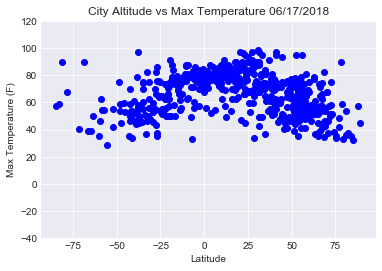

In [60]:
# Build a scatter plot for each data type
plt.scatter(location_data["rand_lat"], location_data["Temp"], marker="o", color = 'blue')

# # Incorporate the other graph properties
plt.title("City Altitude vs Max Temperature " + str(Date))
plt.ylabel("Max Temperature (F)")
plt.xlabel("Latitude")
plt.yticks(np.arange(-40, 130, 20))
plt.grid(True)
sns.set_style('darkgrid')

# # Save the figure
plt.savefig("TemperatureInWorldCities.png")

# Show plot
plt.show()

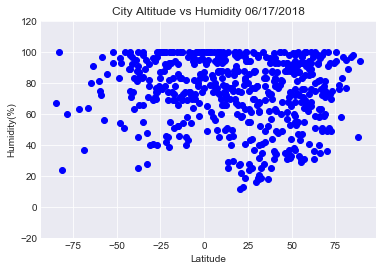

In [61]:
# Build a scatter plot for each data type
plt.scatter(location_data["rand_lat"], location_data["Humidity"], marker="o", color = 'blue')

# # Incorporate the other graph properties
plt.title("City Altitude vs Humidity " + str(Date))
plt.ylabel("Humidity(%)")
plt.xlabel("Latitude")
plt.grid(True)
plt.yticks(np.arange(-20, 130, 20))
sns.set_style('darkgrid')

# # Save the figure
plt.savefig("HumidityInWorldCities.png")

# Show plot
plt.show()

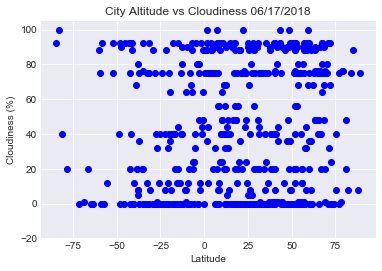

In [62]:
# Build a scatter plot for each data type
plt.scatter(location_data["rand_lat"], location_data["Cloudiness"], marker="o", color = 'blue')

# # Incorporate the other graph properties
plt.title("City Altitude vs Cloudiness " + str(Date))
plt.ylabel("Cloudiness (%)")
plt.xlabel("Latitude")
plt.grid(True)
plt.yticks(np.arange(-20, 120, 20))
sns.set_style('darkgrid')

# # Save the figure
plt.savefig("CloudinessInWorldCities.png")

# Show plot
plt.show()

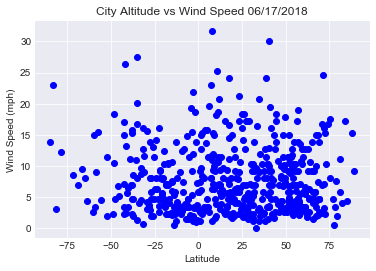

In [63]:
# Build a scatter plot for each data type
plt.scatter(location_data["rand_lat"], location_data["Wind Speed"], marker="o", color = 'blue')

# Incorporate the other graph properties
plt.title("City Altitude vs Wind Speed " + str(Date))
plt.ylabel("Wind Speed (mph)")
plt.xlabel("Latitude")
plt.grid(True)

sns.set_style('darkgrid')

# Save the figure
plt.savefig("WindSpeedInWorldCities.png")

# Show plot
plt.show()